#### Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier

import scratch as s

In [2]:
clinpath = pandas.read_excel('./bbdp/data/Clinicopathological Correlations.xls')
movement = pandas.read_excel('./bbdp/data/Movement Examination.xls')
neuro = pandas.read_excel('./bbdp/data/Neurological Examination.xls')
psych = pandas.read_excel('./bbdp/data/Neuropsychological Examination.xls')
mmse_all = pandas.read_excel('./bbdp/data/MMSE Scores All Sources.xls')
mmse_bbdp = pandas.read_excel('./bbdp/data/MMSE Scores BBDP.xls')
for x in [clinpath,movement,neuro,psych,mmse_all,mmse_bbdp]:
    x.set_index('Donor ID', drop=True, append=False, inplace=True)

In [3]:
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls')
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]]
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data')

smell = df[['donor_id','shri_case_num','stint','deathage','smell_reduced_or_absent']]#+['smell_%d' % q for q in range(1,41)]]
smell.insert(3,'dementia',[np.any([row[col_label]==2 for col_label in dementia_labels]) \
                           for row_label,row in df.iterrows()])
smell.insert(3,'test_age',df['deathage'] - df['stint'])

smell_test_key = pandas.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey')
smell_test_key = smell_test_key['Correct answer']
smell_matrix = df[['smell_%d' % q for q in range(1,41)]].as_matrix()
for q in range(40):
    smell_matrix[:,q] = (smell_matrix[:,q] == smell_test_key[q])
smell.insert(3,'upsit_total',smell_matrix.sum(axis=1))
smell.rename(columns={'donor_id':'Donor ID', 'shri_case_num': 'Case ID'}, inplace=True)

for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        smell.insert(len(list(smell)),'smell_%d%s' % (q,letter),df['smell_%d' % q]==(i+1))

smell.set_index('Donor ID', drop=True, append=False, inplace=True)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [4]:
raw = smell.join(clinpath,how='left',rsuffix='_cp')\
           .join(movement,how='left',rsuffix='_nr')\
           #.join(smell,how='left',rsuffix='_sl')\
           #.join(neuro,how='left',rsuffix='_nr')\
           #.join(psych,how='left',rsuffix='_ps')\
           #.join(mmse_all,how='left',rsuffix='_ma')\
           #.join(mmse_bbdp,how='left',rsuffix='_mb')\
raw.drop(['Case ID'+x for x in ['_cp','_nr','_ps','_ma','_mb','_sl']],inplace=True,axis=1,errors='ignore')
raw.drop(['Donor ID'+x for x in ['_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.drop(['Refresh Date'+x for x in ['','_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.reset_index(inplace=True)

In [5]:
NaN = {}
NaN[99] = ['Autopsy Type','Race','Hispanic','Education Years',
          'Occupation','Handedness','Expired Reason','Plaque Total',
          'Tangle Total','Braak Tangle Score','Lewy Sum Density Brain',
          'Lewy Sum Density Body','CAA Total','CDR Sum','Global D Scale',
          'FAST Score','GERI D Score','Names in 60 Seconds','Figure Recall Score',
          'Clock Drawing','Hachinski Ischemic Score','MMSE Score',
          'MMSE Possible Score','AVLT Total Learning','AVLT Trial 1','AVLT Trial 2',
          'AVLT Trial 3','AVLT Trial 4','AVLT Trial 5','AVLT Intrusions 1-5',
          'AVLT STM A6','AVLT Intrusions STM','AVLT LTM A7','AVLT List B',
          'AVLT Recognition TP','AVLT Recognition FP','Judgement of Line Orientation',
          'WMSR Digit Span Forward Score','WMSR Digit Span Forward Span',
          'WMSR Digit Span Backward Score','WMSR Digit Span Backward Span',
          'WMSR Digit Span Total Score','Trials A Errors','Trails B Errors',
          'UPDRS I Intellectual Impairment','UPDRS I Thought Disorder Score',
          'UPDRS I Depression Score','UPDRS I Motivation Initiative',
          'UPDRS II*','UPDRS III*','UPDRS IV*','Restless Leg Syndrome','RLS Score',
          'Modified Hoehn and Yahr Stage','Postural Tremor Right',
          'Postural Tremor Left','Kinetic Tremor Right','Kinetic Tremor Left',
          'Voice Tremor','Head Tremor','Blepharospasm','OMD',
          'Torticollis','Limb Dystonia','Myoclonus','Tics','Chorea','Downgaze Palsy',
          'Square Wave Jerks','Timed Tapping Score Right','Timed Tapping Score Left',
          'Purdue Pegboard Score Right','Purdue Pegboard Score Left',
          'Purdue Pegboard Both Hands','Control No Movement Disorder DX',
          'Parkinsonism DX','Tremor DX','Dystonia DX','Dystonia Cranial DX',
          'Dystonia Cervical DX','Dystonia Laryngeal DX','Dystonia Limb DX',
          'Dystonia Trunk DX','Chorea DX','Tardive Dyskinesia or Dystonia DX',
          'Myoclonus DX','Tic DX','Ataxia DX','RLS DX','PLMS DX',
          'REM Behavior Disorder DX','NPH DX','PD Symptoms Bradykinesia',
          'PD Symptoms Rest Tremor','PD Symptoms Rigidity',
          'PD Symptoms Postural Instability','PD Symptoms Asymmetric Onset',
          'PD Symptoms Persistent Asymmetry','PD Symptoms Response to TX',
          'PD Symptoms Motor Fluctuations','PD Symptoms Dyskinesia',]
NaN[999] = ['Medical Records Total Months','Last BMI Score',
           'Last BMI Interval Before Death','BMI Mean Score',
           'BMI First to Last Interval','Last MMSE Test Score',
           'Last MMSE Interval Before Death','Last UPDRS Motor Score On Medication',
           'Last UPDRS Motor Score Off Medication','Last UPDRS Interval Before Death',
           'AVLT Percent Recall','Trails A 3 Min Limit','Trails B 5 Minute Limit',
           'Stroop Word Naming','Stroop Color Naming','Stroop Word Color',
           'Stroop Uncorrected Errors','Stroop Interference','COWA Fluency 1',
           'COWA Fluency 2','COWA Fluency Total','COWA Word Perseverations',
           'COWA Fluency Intrusions','COWA Animal Fluency',
           'COWA Animal Perseverations','Hamilton Depression Scale',
           'Hours Since Last PD Med Dose','PD Certainty Percent']
NaN[9] = ['Postmortem Parkinsonism','Postmortem Global CDR Score','MCI',
         'Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD',
         'Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS',
         'Clinpath DLDH','Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD',
         'Clinpath MSA','ARG','Clinpath FTLD-TDP43','TDP43NOS','Plaque Frontal',
         'Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
         'Neuritic Plaque Density','Tangle Frontal','Tangle Temporal',
         'Tangle Parietal','Tangle Hippocampus','Tangle Entorhinal','NIA Reagan',
         'USSLBD','SN Depigmentation','Lewy Olfactory Bulb','Lewy Brainstem IX X',
         'Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala','Lewy Transentorhinal',
         'Lewy Cingulate','Lewy Frontal','Lewy Temporal','Lewy Parietal','Lewy Cervical',
         'Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve',
         'Lewy Submondibular','Lewy Esophagus','CAA Frontal','CAA Temporal',
         'CAA Parietal','CAA Occipital','Circle of Willis','CDR Global',
         'Dystonia Trunk DX']
NaN[900] = ['Clinpath PD']
NaN[9999] = ['Brain Weight Grams','Infarct Cortical Volume',
            'Infarct Centrum Ovale Volume','Infarct Deep Nuclei Volume',
            'Infarct Infratentorial Volume','Infarct Brain Total Volume',
            ]
NaN[8] = ['Circle of Willis','UPDRS II*','UPDRS III*','UPDRS IV*']

In [6]:
clean = raw.copy()

# Replace numeric versions of NaN with actual NaN.  
import fnmatch
for val in NaN.keys():
    features = NaN[val]
    replacements = {}
    for feature in features:
        all_features = list(raw)
        matches = [f for f in all_features if fnmatch.fnmatch(f,feature)]
        #assert len(matches), "No feature matching '%s' was found" % feature
        for match in matches:
            replacements[match] = np.nan
    clean.replace(to_replace=val, value=replacements, inplace=True)
    clean.replace(to_replace=str(val), value=replacements, inplace=True)
    
# Replace letter scores with decimals. 
if 'FAST Score' in list(clean):
    for i,val in enumerate(clean['FAST Score']):
        if type(val) != float:
            for letter,decimal in [('a','.0'),('b','.2'),('c','.4'),('d','.6'),('e','.8')]:
                val = val.replace(letter,decimal)
            clean.set_value(i,'FAST Score',float(val))
        
# Replace hyphens with decimals.  
for i,val in enumerate(clean['Case ID']):
    clean.set_value(i,'Case ID',float(val.replace('-','.')))
        
clean.drop(['Occupation','Expired Reason'],inplace=True,axis=1)

In [178]:
path_cols = ['Brain Weight Grams','MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos',
 'Clinpath AD','Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH',
 'Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD','Clinpath MSA','ARG','Clinpath FTLD-TDP43',
 'TDP43NOS','Plaque Frontal','Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
 'Plaque Total','Neuritic Plaque Density','Tangle Frontal','Tangle Temporal','Tangle Parietal','Tangle Hippocampus',
 'Tangle Entorhinal','Tangle Total','Braak Tangle Score','NIA Reagan','USSLBD','SN Depigmentation',
 'Lewy Olfactory Bulb','Lewy Brainstem IX X','Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala',
 'Lewy Transentorhinal','Lewy Cingulate','Lewy Temporal','Lewy Frontal','Lewy Parietal','Lewy Sum Density Brain',
 'Lewy Cervical','Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve','Lewy Submondibular',
 'Lewy Esophagus','Lewy Sum Density Body','CAA Frontal','CAA Temporal','CAA Parietal','CAA Occipital',
 'CAA Total','Circle of Willis','Infarct Cortical Volume','Infarct Centrum Ovale Volume',
 'Infarct Deep Nuclei Volume','Infarct Infratentorial Volume','Infarct Brain Total Volume']
binary_cols = ['MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD','Clinpath PD',
                'Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH','Clinpath MND',
                'Clinpath CBD','ARG','Clinpath FTLD-TDP43']
Y_clean = clean[binary_cols]
#Y_clean = clean[path_cols]
X_clean = clean.drop(path_cols,axis=1).drop(['Donor ID','Case ID'],axis=1)
X_clean_nosmell = X_clean.drop(list(smell),axis=1,errors='ignore')
X_clean_nopark = X_clean.drop([x for x in list(X_clean) if any([a in x for a in ['Park','PD']])],axis=1)

In [179]:
imps = ['knn',]#'nnm','softimpute']
X = s.imputation(X_clean,imps=imps)
Y = s.imputation(Y_clean,imps=imps)
X_nosmell = s.imputation(X_clean_nosmell,imps=imps)
X_nopark = s.imputation(X_clean_nopark,imps=imps)

Computing pairwise distances between 879 samples
Computing distances for sample #1/879, elapsed time: 0.157
Computing distances for sample #101/879, elapsed time: 0.279
Computing distances for sample #201/879, elapsed time: 0.399
Computing distances for sample #301/879, elapsed time: 0.518
Computing distances for sample #401/879, elapsed time: 0.638
Computing distances for sample #501/879, elapsed time: 0.758
Computing distances for sample #601/879, elapsed time: 0.877
Computing distances for sample #701/879, elapsed time: 0.996
Computing distances for sample #801/879, elapsed time: 1.114
Imputing row 1/879 with 62 missing columns, elapsed time: 1.248
Imputing row 101/879 with 73 missing columns, elapsed time: 1.325
Imputing row 201/879 with 73 missing columns, elapsed time: 1.402
Imputing row 301/879 with 76 missing columns, elapsed time: 1.478
Imputing row 401/879 with 52 missing columns, elapsed time: 1.552
Imputing row 501/879 with 35 missing columns, elapsed time: 1.624
Imputing r

In [164]:
# Fit the model, using cross-validation with 100 train/test splits.  
rs,feature_importances,ys,ps = s.fit_models(imps,X,Y,Y_clean,n_estimators=100,n_splits=25)

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


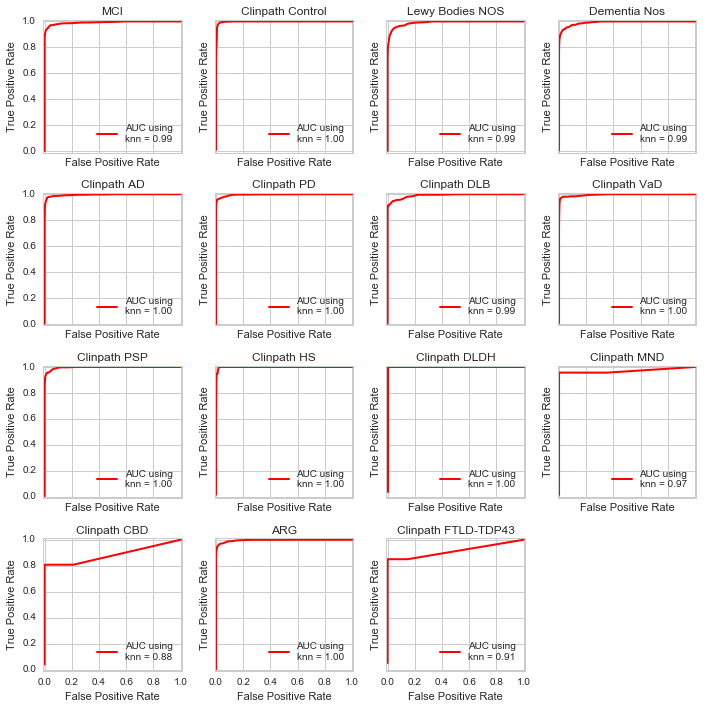

In [165]:
s.plot_just_rocs(Y_clean,ps,ys,imps)

In [116]:
# Correlations between predictions and observations for the holdout data:
# report(rs,Y_clean,imps)

In [166]:
# Feature importances, ranked by number and location of appearances in the ensemble of decision trees
s.display_importances(X_clean,Y_clean,feature_importances)

,MCI,Clinpath Control,Lewy Bodies NOS,Dementia Nos,Clinpath AD,Clinpath PD,Clinpath DLB,Clinpath VaD,Clinpath PSP,Clinpath HS,Clinpath DLDH,Clinpath MND,Clinpath CBD,ARG,Clinpath FTLD-TDP43
0,"(Last BMI Score, 0.033)","(Last MMSE Test Score, 0.079)","(Last MMSE Test Score, 0.028)","(dementia, 0.034)","(Last MMSE Test Score, 0.102)","(Hours Since Last PD Med Dose, 0.075)","(Last MMSE Test Score, 0.032)","(Last UPDRS Interval Before Death, 0.048)","(test_age, 0.045)","(test_age, 0.05)","(Last BMI Score, 0.097)","(Last BMI Score, 0.103)","(PMI, 0.039)","(stint, 0.027)","(deathage, 0.03)"
1,"(Last MMSE Test Score, 0.033)","(Last UPDRS Motor Score Off Medication, 0.036)","(Medical Records Latest, 0.024)","(deathage, 0.029)","(UPDRS I Intellectual Impairment, 0.025)","(Last UPDRS Motor Score Off Medication, 0.043)","(Parkinsonism DX, 0.031)","(stint, 0.03)","(deathage, 0.03)","(PD Symptoms Postural Instability, 0.048)","(BMI Mean Score, 0.04)","(BMI Mean Score, 0.096)","(BMI First to Last Interval, 0.037)","(Last BMI Interval Before Death, 0.021)","(UPDRS III Hand Movement Right PD Not Related,..."
2,"(Medical Records Latest, 0.032)","(Parkinsonism DX, 0.033)","(Last UPDRS Motor Score Off Medication, 0.022)","(test_age, 0.027)","(stint, 0.022)","(PD Symptoms Response to TX, 0.036)","(Last UPDRS Interval Before Death, 0.019)","(Last BMI Interval Before Death, 0.027)","(stint, 0.018)","(deathage, 0.044)","(Expired Age, 0.039)","(BMI First to Last Interval, 0.03)","(Last MMSE Interval Before Death, 0.027)","(BMI First to Last Interval, 0.021)","(smell_22d, 0.02)"
3,"(BMI Mean Score, 0.032)","(upsit_total, 0.032)","(Medical Records Earliest, 0.019)","(Expired Age, 0.024)","(Last UPDRS Interval Before Death, 0.018)","(PD Certainty Percent, 0.028)","(Last BMI Interval Before Death, 0.017)","(PMI, 0.025)","(Medical Records Total Months, 0.017)","(Last MMSE Test Score, 0.037)","(Parkinsonism DX, 0.038)","(UPDRS III Leg Agility Right Off, 0.026)","(deathage, 0.024)","(PMI, 0.02)","(smell_8c, 0.019)"
4,"(PMI, 0.026)","(UPDRS I Intellectual Impairment, 0.02)","(Last MMSE Interval Before Death, 0.017)","(UPDRS II Freezing When Walking Off, 0.022)","(smell_30d, 0.017)","(Parkinsonism DX, 0.027)","(Medical Records Total Months, 0.015)","(Last MMSE Interval Before Death, 0.025)","(Expired Age, 0.016)","(PD Symptoms Bradykinesia, 0.037)","(UPDRS III Rigidity LLE Off, 0.026)","(smell_34d, 0.024)","(smell_33a, 0.023)","(Last UPDRS Interval Before Death, 0.017)","(smell_20b, 0.019)"
5,"(stint, 0.02)","(UPDRS III Body Bradykinesia Off, 0.018)","(stint, 0.016)","(BMI Mean Score, 0.019)","(Last BMI Interval Before Death, 0.017)","(UPDRS III Body Bradykinesia Off, 0.023)","(stint, 0.014)","(Medical Records Total Months, 0.024)","(BMI Mean Score, 0.015)","(Medical Records Total Months, 0.027)","(deathage, 0.025)","(smell_32d, 0.022)","(Timed Tapping Score Left, 0.021)","(deathage, 0.016)","(Last UPDRS Interval Before Death, 0.019)"
6,"(Medical Records Earliest, 0.018)","(Modified Hoehn and Yahr Stage, 0.018)","(BMI Mean Score, 0.016)","(Last BMI Score, 0.016)","(BMI Mean Score, 0.017)","(Modified Hoehn and Yahr Stage, 0.023)","(smell_8d, 0.014)","(Medical Records Earliest, 0.021)","(BMI First to Last Interval, 0.015)","(PD Symptoms Persistent Asymmetry, 0.025)","(upsit_total, 0.02)","(upsit_total, 0.021)","(Medical Records Total Months, 0.019)","(Last BMI Score, 0.016)","(UPDRS III Hand Movement Left PD Not Related, ..."
7,"(Medical Records Total Months, 0.017)","(stint, 0.017)","(Medical Records Total Months, 0.015)","(Medical Records Earliest, 0.015)","(PMI, 0.015)","(PD Symptoms Motor Fluctuations, 0.019)","(smell_28d, 0.014)","(deathage, 0.02)","(upsit_total, 0.014)","(PD Symptoms Asymmetric Onset, 0.024)","(test_age, 0.02)","(deathage, 0.02)","(Last UPDRS Interval Before Death, 0.019)","(BMI Mean Score, 0.015)","(PD Symptoms Bradykinesia, 0.018)"
8,"(upsit_total, 0.015)","(test_age, 0.014)","(Last BMI Score, 0.015)","(Medical Records Total Months, 0.0

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


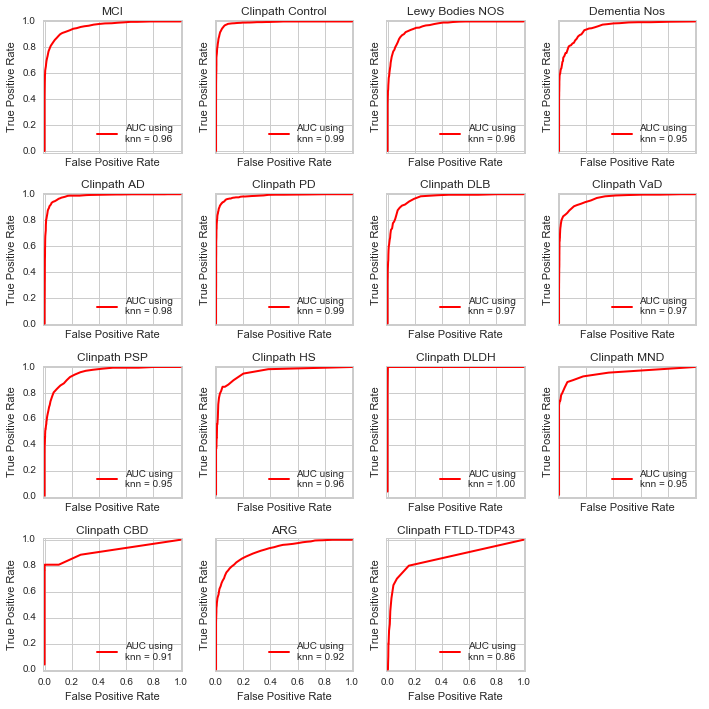

In [167]:
# Re-run, using no smell information for prediction.
rs,feature_importances,ys,ps = s.fit_models(imps,X_nosmell,Y,Y_clean,n_estimators=100,n_splits=25)
s.plot_just_rocs(Y_clean,ps,ys,imps)

Fitting model for MCI...
Fitting model for Clinpath Control...
Fitting model for Lewy Bodies NOS...
Fitting model for Dementia Nos...
Fitting model for Clinpath AD...
Fitting model for Clinpath PD...
Fitting model for Clinpath DLB...
Fitting model for Clinpath VaD...
Fitting model for Clinpath PSP...
Fitting model for Clinpath HS...
Fitting model for Clinpath DLDH...
Fitting model for Clinpath MND...
Fitting model for Clinpath CBD...
Fitting model for ARG...
Fitting model for Clinpath FTLD-TDP43...


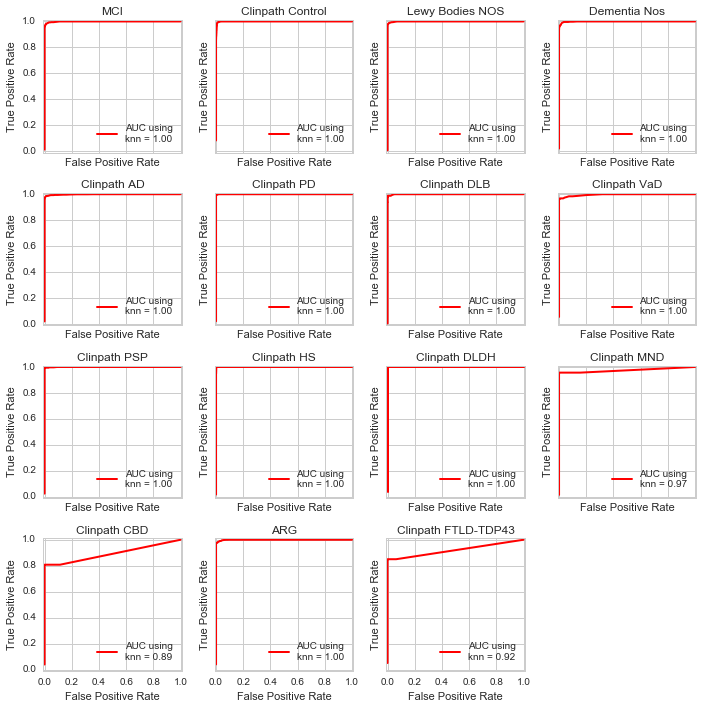

In [180]:
# Re-run, using no PD diagnosis information for prediction.
rs,feature_importances,ys,ps = s.fit_models(imps,X_nopark,Y,Y_clean,n_estimators=100,n_splits=25)
s.plot_just_rocs(Y_clean,ps,ys,imps)

In [183]:
# Feature importances, ranked by number and location of appearances in the ensemble of decision trees
s.display_importances(X_clean_nopark,Y_clean,feature_importances)

,MCI,Clinpath Control,Lewy Bodies NOS,Dementia Nos,Clinpath AD,Clinpath PD,Clinpath DLB,Clinpath VaD,Clinpath PSP,Clinpath HS,Clinpath DLDH,Clinpath MND,Clinpath CBD,ARG,Clinpath FTLD-TDP43
0,"(Last MMSE Test Score, 0.049)","(Last MMSE Test Score, 0.105)","(Last MMSE Test Score, 0.047)","(dementia, 0.069)","(Last MMSE Test Score, 0.146)","(Modified Hoehn and Yahr Stage, 0.074)","(Last MMSE Test Score, 0.044)","(deathage, 0.039)","(test_age, 0.062)","(test_age, 0.091)","(Last BMI Score, 0.111)","(BMI Mean Score, 0.157)","(PMI, 0.068)","(stint, 0.036)","(smell_8c, 0.05)"
1,"(BMI Mean Score, 0.045)","(upsit_total, 0.052)","(Medical Records Latest, 0.031)","(deathage, 0.048)","(stint, 0.031)","(dementia, 0.056)","(smell_8d, 0.024)","(Last MMSE Interval Before Death, 0.039)","(deathage, 0.047)","(deathage, 0.081)","(BMI Mean Score, 0.105)","(Last BMI Score, 0.103)","(BMI First to Last Interval, 0.044)","(BMI First to Last Interval, 0.034)","(smell_16a, 0.046)"
2,"(Last BMI Score, 0.042)","(Modified Hoehn and Yahr Stage, 0.045)","(stint, 0.028)","(test_age, 0.046)","(Last BMI Interval Before Death, 0.025)","(test_age, 0.055)","(Last BMI Interval Before Death, 0.024)","(Last BMI Interval Before Death, 0.037)","(stint, 0.029)","(Last MMSE Test Score, 0.064)","(test_age, 0.047)","(BMI First to Last Interval, 0.047)","(smell_33a, 0.037)","(Last BMI Interval Before Death, 0.031)","(deathage, 0.044)"
3,"(Medical Records Latest, 0.041)","(test_age, 0.033)","(Last MMSE Interval Before Death, 0.027)","(BMI Mean Score, 0.036)","(BMI Mean Score, 0.025)","(deathage, 0.042)","(Medical Records Total Months, 0.022)","(stint, 0.035)","(Medical Records Total Months, 0.026)","(Medical Records Total Months, 0.044)","(smell_39a, 0.04)","(upsit_total, 0.032)","(Timed Tapping Score Left, 0.036)","(PMI, 0.03)","(test_age, 0.035)"
4,"(PMI, 0.032)","(stint, 0.024)","(Medical Records Total Months, 0.026)","(Expired Age, 0.031)","(Last MMSE Interval Before Death, 0.024)","(upsit_total, 0.037)","(stint, 0.02)","(PMI, 0.035)","(upsit_total, 0.025)","(stint, 0.041)","(upsit_total, 0.032)","(smell_34d, 0.032)","(test_age, 0.032)","(deathage, 0.027)","(smell_15d, 0.033)"
5,"(stint, 0.031)","(dementia, 0.023)","(test_age, 0.025)","(Last BMI Score, 0.028)","(upsit_total, 0.021)","(Expired Age, 0.026)","(smell_2a, 0.02)","(Medical Records Total Months, 0.033)","(Last MMSE Interval Before Death, 0.025)","(PMI, 0.037)","(deathage, 0.032)","(smell_32d, 0.031)","(smell_32d, 0.032)","(BMI Mean Score, 0.026)","(smell_5b, 0.031)"
6,"(Medical Records Earliest, 0.029)","(deathage, 0.023)","(Medical Records Earliest, 0.025)","(Medical Records Total Months, 0.026)","(Medical Records Total Months, 0.021)","(smell_24a, 0.023)","(smell_40b, 0.02)","(Medical Records Earliest, 0.03)","(BMI First to Last Interval, 0.024)","(Medical Records Earliest, 0.034)","(Expired Age, 0.032)","(smell_9a, 0.027)","(smell_29c, 0.028)","(Last BMI Score, 0.025)","(stint, 0.026)"
7,"(Medical Records Total Months, 0.027)","(Timed Tapping Score Right, 0.023)","(BMI First to Last Interval, 0.025)","(stint, 0.022)","(deathage, 0.02)","(smell_19b, 0.019)","(Movement Exam ID, 0.018)","(test_age, 0.026)","(BMI Mean Score, 0.023)","(Movement Exam ID, 0.031)","(smell_4c, 0.026)","(deathage, 0.022)","(deathage, 0.027)","(test_age, 0.023)","(smell_11d, 0.024)"
8,"(test_age, 0.026)","(Last BMI Interval Before Death, 0.018)","(deathage, 0.024)","(Medical Records Earliest, 0.022)","(PMI, 0.02)","(Last MMSE Test Score, 0.018)","(BMI First to Last Interval, 0.017)","(BMI First to Last Interval, 0.026)","(dementia, 0.022)","(BMI First to Last Interval, 0.026)","(Medical Records Earliest, 0.021)","(smell_19c, 0.021)","(Last MMSE Interval Before Death, 0.023)","(Last MMSE Interval Before Death, 0.023)","(smell_25b, 0.021)"
9,"(upsit_total, 0.023)","(smell_24a, 0.017)","(Last BMI Score, 0.024)","(Modified Hoehn and Yahr Stage, 0.021)","(BMI First to Last Interval, 0.02)","(smell_16d, 0.017)","(upsit_total, 0.016)","(Last